# Import All Dependencies

In [1]:
import pandas as pd
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle

# Load Dataset

In [2]:
data = pd.read_csv('data.tsv', sep='\t') # Read the data from a TSV (Tab-Separated Values) file into a DataFrame
data = data.reset_index() # Reset the index turning the index into a column beacause when load the the dataset it's have one column and two index
data = data.rename(columns={'level_0': 'word', 'level_1': 'pos', 'শনিবার (২৭ আগস্ট) রাতে পটুয়াখালী সদর থানার ভারপ্রাপ্ত কর্মকর্তা (ওসি) মো. মনিরুজ্জামান এ তথ্য নিশ্চিত করেছেন।':'ner'}) # Rename the columns after reindexing
data.head(10) # # Display the first 10 rows

,word,pos,ner
0,শনিবার,NNP,B-D&T
1,(২৭,PUNCT,B-OTH
2,আগস্ট),NNP,B-D&T
3,রাতে,NNC,B-D&T
4,পটুয়াখালী,NNP,B-GPE
5,সদর,NNC,I-GPE
6,থানার,NNC,I-GPE
7,ভারপ্রাপ্ত,ADJ,B-PER
8,কর্মকর্তা,NNC,I-PER
9,(ওসি),PUNCT,B-OTH


# Data Visualization

In [3]:
data.info() # Check column names, data type, index range, have null value or not and memory uses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49383 entries, 0 to 49382
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    49383 non-null  object
 1   pos     45326 non-null  object
 2   ner     45324 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [4]:
data.isna().sum() # count null value

word       0
pos     4057
ner     4059
dtype: int64

## Remove null value and clean data

In [5]:
data.dropna(inplace=True) # Handle missing values
data['word'] = data['word'].str.strip() # Normalize text 
data['word'] = data['word'].str.replace(r'[^\w\s]', '', regex=True)# Remove unnecessary symbols

### Counter plot both NER and POS data

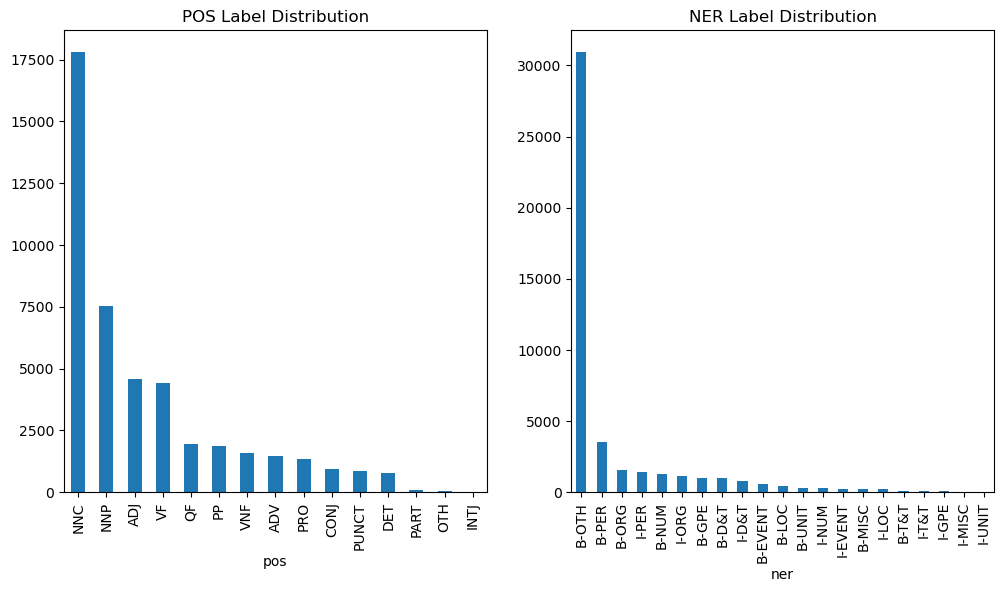

In [6]:
pos_label_counts = data['pos'].value_counts() # Count unique value in the 'pos' column
ner_label_counts = data['ner'].value_counts() # Count unique value in the 'ner' column
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
pos_label_counts.plot(kind='bar')
plt.title('POS Label Distribution')
plt.subplot(1, 2, 2)
ner_label_counts.plot(kind='bar')
plt.title('NER Label Distribution')
plt.show()

# Tokenize and pad sequences

In [7]:
# Tokenization for words
tokenizer = Tokenizer() # Initialize the Tokenizer
tokenizer.fit_on_texts(data['word'].values) # Fit the tokenizer on the text data in the 'word' column of the DataFrame
tokenizer

In [8]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f) # # Save the tokenizer object to the file for using inference time or model deploment time

In [9]:
word_index = tokenizer.word_index # dictionary mapping words to their integer index
sequences = tokenizer.texts_to_sequences(data['word'].values) # Convert the text in the 'word' column to sequences of integers

### Padding sequences

In [11]:
max_len = max([len(seq) for seq in sequences]) # Find the maximum length of the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post') # Pad the sequences so that they all have the same length
max_len,padded_sequences

(31,
 array([[  232,     0,     0, ...,     0,     0,     0],
        [  815,     0,     0, ...,     0,     0,     0],
        [  312,     0,     0, ...,     0,     0,     0],
        ...,
        [  405,     0,     0, ...,     0,     0,     0],
        [11238,     0,     0, ...,     0,     0,     0],
        [    7,     0,     0, ...,     0,     0,     0]]))

In [13]:
pos_tags = list(data['pos'].unique()) #list of unique POS tags
ner_tags = list(data['ner'].unique()) #list of unique NER tags
pos_tags, ner_tags

(['NNP',
  'PUNCT',
  'NNC',
  'ADJ',
  'DET',
  'VF',
  'CONJ',
  'PRO',
  'VNF',
  'PP',
  'QF',
  'ADV',
  'PART',
  'OTH',
  'INTJ'],
 ['B-D&T',
  'B-OTH',
  'B-GPE',
  'I-GPE',
  'B-PER',
  'I-PER',
  'B-LOC',
  'I-LOC',
  'B-ORG',
  'B-EVENT',
  'I-EVENT',
  'B-NUM',
  'I-ORG',
  'I-D&T',
  'B-UNIT',
  'B-MISC',
  'B-T&T',
  'I-NUM',
  'I-T&T',
  'I-MISC',
  'I-UNIT'])

In [14]:
pos_tag_to_index = {tag: idx for idx, tag in enumerate(pos_tags)} # # Create a dictionary that maps each POS tag this dictionary comprehension creates key-value pairs where the key is the tag and the value is its index
ner_tag_to_index = {tag: idx for idx, tag in enumerate(ner_tags)} # Create a dictionary that maps each NER tag 
pos_tag_to_index, ner_tag_to_index

({'NNP': 0,
  'PUNCT': 1,
  'NNC': 2,
  'ADJ': 3,
  'DET': 4,
  'VF': 5,
  'CONJ': 6,
  'PRO': 7,
  'VNF': 8,
  'PP': 9,
  'QF': 10,
  'ADV': 11,
  'PART': 12,
  'OTH': 13,
  'INTJ': 14},
 {'B-D&T': 0,
  'B-OTH': 1,
  'B-GPE': 2,
  'I-GPE': 3,
  'B-PER': 4,
  'I-PER': 5,
  'B-LOC': 6,
  'I-LOC': 7,
  'B-ORG': 8,
  'B-EVENT': 9,
  'I-EVENT': 10,
  'B-NUM': 11,
  'I-ORG': 12,
  'I-D&T': 13,
  'B-UNIT': 14,
  'B-MISC': 15,
  'B-T&T': 16,
  'I-NUM': 17,
  'I-T&T': 18,
  'I-MISC': 19,
  'I-UNIT': 20})

In [15]:
# Convert POS and NER tags to integer labels
data['pos'] = data['pos'].map(pos_tag_to_index)
data['ner'] = data['ner'].map(ner_tag_to_index)

In [16]:
# Convert POS and NER labels into sequences (to match the input sequences)
pos_sequences = data['pos'].values.reshape(-1, 1)
ner_sequences = data['ner'].values.reshape(-1, 1)

In [17]:
# Padding the POS and NER sequences to match the input sequences
pos_padded = pad_sequences(pos_sequences, maxlen=max_len, padding='post')
ner_padded = pad_sequences(ner_sequences, maxlen=max_len, padding='post')

### split the dataset into training, validation, and test sets

In [18]:
# Splitting the data, ensuring that all splits have consistent sample sizes
X_train, X_temp, y_train_pos, y_temp_pos, y_train_ner, y_temp_ner = train_test_split(padded_sequences, pos_padded, ner_padded, test_size=0.3, random_state=42)  ## for train session have 70% of the data, while test have 30%
X_val, X_test, y_val_pos, y_test_pos, y_val_ner, y_test_ner = train_test_split(X_temp, y_temp_pos, y_temp_ner, test_size=0.5, random_state=42) # for validation contain 15% of the original data, while test the other 15%

## Neural Network Architecture
An embedding layer is used in this neural network to represent input sequences as dense vectors. A dropout layer and a bidirectional LSTM are then used to extract contextual information. It uses two output branches, one for NER and one for POS tagging. Time-distributed dense layers with softmax activation are used in both. The sparse categorical crossentropy loss and Adam optimizer are used in the model's compilation, and accuracy is monitored for both outputs.

In [20]:
input = Input(shape=(max_len,)) # Define the input layer with shape equal to the maximum sequence length
model = Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_len)(input)
model = Dropout(0.3)(model) # # Dropout layer to prevent overfitting by randomly setting a fraction (0.3) 
model = Bidirectional(LSTM(units=64, return_sequences=True))(model) # # Bidirectional LSTM layer units=64 means 64 LSTM units; return_sequences=True allows the LSTM to output the full sequence
pos_output = TimeDistributed(Dense(len(pos_tags), activation="softmax"))(model) # POS tagging output
ner_output = TimeDistributed(Dense(len(ner_tags), activation="softmax"))(model) # NER output
model = Model(inputs=input, outputs=[pos_output, ner_output]) # Combine outputs into a single model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy", "accuracy"])  # Two accuracies, one for each output)
model.summary()

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 31)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 31, 128)           │       1,438,592 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 31, 128)           │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 31, 128)           │          98,816 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 31, 15)            │           1,935 │ bidirectional[0][0]        │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed_1            │ (None, 31, 21)            │           2,709 │ bidirectional[0][0]        │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,542,052 (5.88 MB)

 Trainable params: 1,542,052 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model on the preprocessed dataset.

In [21]:
history = model.fit(X_train, [y_train_pos, y_train_ner], validation_data=(X_val, [y_val_pos, y_val_ner]), epochs=10, batch_size=32)

Epoch 1/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 59s 45ms/step - loss: 0.3219 - time_distributed_1_accuracy: 0.9779 - time_distributed_accuracy: 0.9728 - val_loss: 0.0830 - val_time_distributed_1_accuracy: 0.9896 - val_time_distributed_accuracy: 0.9857
Epoch 2/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - loss: 0.0697 - time_distributed_1_accuracy: 0.9907 - time_distributed_accuracy: 0.9894 - val_loss: 0.0628 - val_time_distributed_1_accuracy: 0.9917 - val_time_distributed_accuracy: 0.9910
Epoch 3/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 0.0475 - time_distributed_1_accuracy: 0.9930 - time_distributed_accuracy: 0.9941 - val_loss: 0.0569 - val_time_distributed_1_accuracy: 0.9927 - val_time_distributed_accuracy: 0.9911
Epoch 4/10
992/992 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 0.0371 - time_distributed_1_accuracy: 0.9946 - time_distributed_accuracy: 0.9949 - val_loss: 0.0547 - val_time_distributed_1_accuracy: 0.9934 - val_time_distributed_accuracy: 0.9913
Epoch 5/10
992/992 ━━━━━

# Model Evaluation
### Report performance metrics such as accuracy, precision, recall, and F1 score are given below

In [23]:
loss, pos_accuracy, ner_accuracy = model.evaluate(X_test, [y_test_pos, y_test_ner])
print(f"Test Loss: {loss}")
print(f"Test POS Accuracy: {pos_accuracy}")
print(f"Test NER Accuracy: {ner_accuracy}")
pos_pred, ner_pred = model.predict(X_test)
pos_pred_indices = pos_pred.argmax(axis=-1)
ner_pred_indices = ner_pred.argmax(axis=-1)
index_to_pos_tag = {idx: tag for tag, idx in pos_tag_to_index.items()}
index_to_ner_tag = {idx: tag for tag, idx in ner_tag_to_index.items()}
pos_pred_tags = [[index_to_pos_tag.get(idx, 'O') for idx in sentence] for sentence in pos_pred_indices]
ner_pred_tags = [[index_to_ner_tag.get(idx, 'O') for idx in sentence] for sentence in ner_pred_indices]
pos_true_tags = [[index_to_pos_tag.get(idx, 'O') for idx in sentence] for sentence in y_test_pos]
ner_true_tags = [[index_to_ner_tag.get(idx, 'O') for idx in sentence] for sentence in y_test_ner]
pos_pred_flat = [tag for sublist in pos_pred_tags for tag in sublist]
ner_pred_flat = [tag for sublist in ner_pred_tags for tag in sublist]
pos_true_flat = [tag for sublist in pos_true_tags for tag in sublist]
ner_true_flat = [tag for sublist in ner_true_tags for tag in sublist]
print("POS Tagging Classification Report:")
print(classification_report(pos_true_flat, pos_pred_flat))
print("NER Tagging Classification Report:")
print(classification_report(ner_true_flat, ner_pred_flat))

213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0544 - time_distributed_1_accuracy: 0.9937 - time_distributed_accuracy: 0.9908
Test Loss: 0.05431773141026497
Test POS Accuracy: 0.9936284422874451
Test NER Accuracy: 0.9909752607345581
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
POS Tagging Classification Report:


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.79      0.61      0.69       706
         ADV       0.81      0.59      0.68       228
        CONJ       0.87      0.98      0.92       148
         DET       0.93      0.86      0.89       111
        INTJ       0.00      0.00      0.00         1
         NNC       0.86      0.68      0.76      2570
         NNP       1.00      1.00      1.00    205129
         OTH       0.00      0.00      0.00         5
        PART       1.00      0.13      0.24        15
          PP       0.66      0.94      0.77       284
         PRO       0.85      0.85      0.85       206
       PUNCT       0.72      0.33      0.46       141
          QF       0.78      0.76      0.77       278
          VF       0.91      0.78      0.84       685
         VNF       0.59      0.60      0.60       262

    accuracy                           0.99    210769
   macro avg       0.72      0.61      0.63    210769
weighted avg       0.99   

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-D&T       1.00      1.00      1.00    204121
     B-EVENT       0.65      0.49      0.56        81
       B-GPE       0.65      0.52      0.58       144
       B-LOC       0.39      0.16      0.23        57
      B-MISC       0.64      0.31      0.42        29
       B-NUM       0.72      0.72      0.72       176
       B-ORG       0.60      0.38      0.46       239
       B-OTH       0.85      0.96      0.90      4679
       B-PER       0.76      0.47      0.58       529
       B-T&T       0.40      0.12      0.18        17
      B-UNIT       0.52      0.79      0.62        42
       I-D&T       0.66      0.34      0.45       114
     I-EVENT       0.59      0.33      0.42        40
       I-GPE       0.00      0.00      0.00         7
       I-LOC       0.29      0.15      0.20        33
      I-MISC       0.25      0.20      0.22         5
       I-NUM       0.57      0.67      0.61        39
       I-ORG       0.58    

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# # Save the model

In [24]:
model.save('pos_ner_model.h5')